# 📊 Análisis Exploratorio de Datos (EDA) - LaLiga, Premier League, Bundesliga

## Objetivo
Analizar datos históricos (2023) y parciales (2024/25, `status=FT`) de LaLiga, Premier League y Bundesliga desde BigQuery para:
- Explorar goles (total, local, visita), distribución 1X2, ventaja de local, BTTS y O/U (0.5-3.5).
- Validar datos: completitud (2023) y consistencia (2024/25 parcial).
- Generar insights para el MVP de predicción (1X2, BTTS, O/U).

## Estructura
1. **Configuración**: Inicialización de librerías y conexión a BigQuery.
2. **Carga de Datos**: Obtener datos de `football_ds.fixtures` (2023) y `football_ds.fixtures_2024_ft` (2024/25).
3. **Limpieza**: Asegurar datos numéricos y sin nulos.
4. **Análisis por Liga**: Métricas y visualizaciones (goles, 1X2, BTTS, O/U).
5. **Resumen Comparativo**: Tabla con métricas clave.
6. **Exportación**: CSVs y gráficos PNG.

## Notas
- Usa datos de `football_ds.fixtures` (2015-2024) y `football_ds.fixtures_2024_ft` (2024/25).
- Exporta resultados a `data/analysis/`.
- Instala dependencias: `pip install --upgrade bottleneck google-cloud-bigquery-storage`.
- Exporta a HTML: `jupyter nbconvert --to html notebooks/exploration_laliga.ipynb`.

In [1]:
# 📦 Configuración de Librerías
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery

# Configurar pandas y matplotlib
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (8, 5)
%matplotlib inline

# Configuración de BigQuery
PROJECT_ID = "football-prediction-2025"
CREDENTIALS_JSON = "/Users/B-yond/Documents/Sports Machine Learning/football_model/config/credentials.json"

# Setear credenciales si no están definidas
if not os.environ.get("GOOGLE_APPLICATION_CREDENTIALS"):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = CREDENTIALS_JSON

print("Inicializando cliente de BigQuery…")
client = bigquery.Client(project=PROJECT_ID)
try:
    _ = list(client.list_datasets())  # Sanity check
    print("✅ Conexión a BigQuery verificada")
except Exception as e:
    raise SystemExit(f"❌ Error al conectar con BigQuery: {e}")

Inicializando cliente de BigQuery…
✅ Conexión a BigQuery verificada


## 🗄️ Funciones de Carga y Análisis

Definimos funciones reutilizables para cargar datos y calcular métricas.

In [2]:
# Función para cargar datos de una liga
def load_league(season, table='fixtures', league='La Liga', status='FT'):
    query = f"""
    SELECT fixture_id, date, league, season, home_team, away_team,
           CAST(goals_home AS INT64) AS goals_home,
           CAST(goals_away AS INT64) AS goals_away, status
    FROM `football_ds.{table}`
    WHERE league = '{league}' AND season = {season} AND status = '{status}'
    """
    df = client.query(query).to_dataframe()
    df = df.dropna(subset=['goals_home', 'goals_away']).copy()
    df['goals_home'] = df['goals_home'].astype(int)
    df['goals_away'] = df['goals_away'].astype(int)
    df['total_goals'] = df['goals_home'] + df['goals_away']
    df['date'] = pd.to_datetime(df['date'])
    return df

# Función para calcular 1X2
def result_row(r):
    if r['goals_home'] > r['goals_away']:
        return 'Home Win'
    if r['goals_home'] < r['goals_away']:
        return 'Away Win'
    return 'Draw'

# Función para calcular O/U
def ou_rates(df):
    tg = df['total_goals']
    return {
        'O0.5': (tg > 0.5).mean(),
        'O1.5': (tg > 1.5).mean(),
        'O2.5': (tg > 2.5).mean(),
        'O3.5': (tg > 3.5).mean(),
        'U0.5': (tg <= 0.5).mean(),
        'U1.5': (tg <= 1.5).mean(),
        'U2.5': (tg <= 2.5).mean(),
        'U3.5': (tg <= 3.5).mean(),
    }

# Función para calcular BTTS
def btts_rate(df):
    return ((df['goals_home'] > 0) & (df['goals_away'] > 0)).mean()

## 📈 Análisis por Liga

Analizamos LaLiga, Premier League y Bundesliga para 2023 (completa) y 2024/25 (parcial).

In [3]:
# Cargar datos
leagues = ['La Liga', 'Premier League', 'Bundesliga']
data_2023 = {}
data_2025 = {}

for league in leagues:
    print(f"Cargando datos para {league}...")
    data_2023[league] = load_league(2023, table='fixtures', league=league)
    data_2025[league] = load_league(2025, table='fixtures_2024_ft', league=league)
    print(f"✅ {league} 2023: {data_2023[league].shape[0]} partidos")
    print(f"✅ {league} 2024/25: {data_2025[league].shape[0]} partidos")

Cargando datos para La Liga...
✅ La Liga 2023: 380 partidos
✅ La Liga 2024/25: 90 partidos
Cargando datos para Premier League...
✅ Premier League 2023: 380 partidos
✅ Premier League 2024/25: 80 partidos
Cargando datos para Bundesliga...
✅ Bundesliga 2023: 307 partidos
✅ Bundesliga 2024/25: 63 partidos


## 🔍 Métricas y Visualizaciones

Calculamos métricas (goles, 1X2, BTTS, O/U) y generamos histogramas.


📊 Análisis para La Liga

--- La Liga 2023 (Completa) ---
Partidos: 380
Goles promedio por partido: 2.645
Goles local promedio: 1.484
Goles visita promedio: 1.161


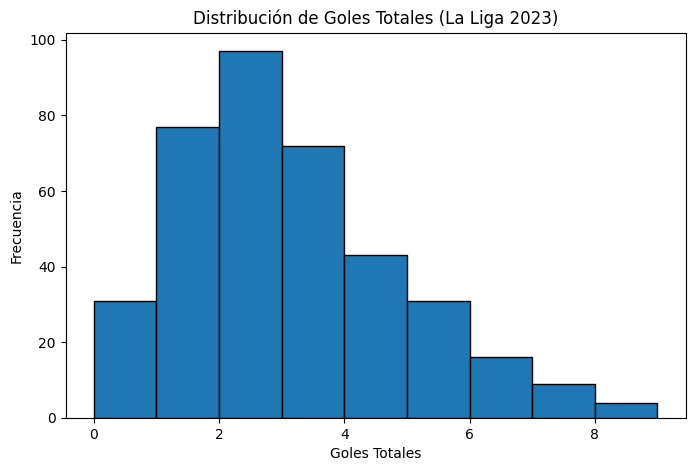

Distribución 1X2 (%):
result
Home Win    43.95
Draw        28.16
Away Win    27.89
Name: proportion, dtype: float64
Home win rate: 43.95%
Over/Under (%): {'O0.5': 91.84, 'O1.5': 71.58, 'O2.5': 46.05, 'O3.5': 27.11, 'U0.5': 8.16, 'U1.5': 28.42, 'U2.5': 53.95, 'U3.5': 72.89}
BTTS (%): 49.47
Top 5 goleadores (GF):
home_team
Real Madrid        87
Girona             85
Barcelona          79
Atletico Madrid    70
Villarreal         65
dtype: int64
Top 5 menos goleados (GA):
home_team
Real Madrid        26
Athletic Club      37
Real Sociedad      39
Atletico Madrid    43
Barcelona          44
dtype: int64

--- La Liga 2024/25 (Parcial, FT) ---
Partidos: 90
Goles promedio por partido: 2.611
Goles local promedio: 1.456
Goles visita promedio: 1.156


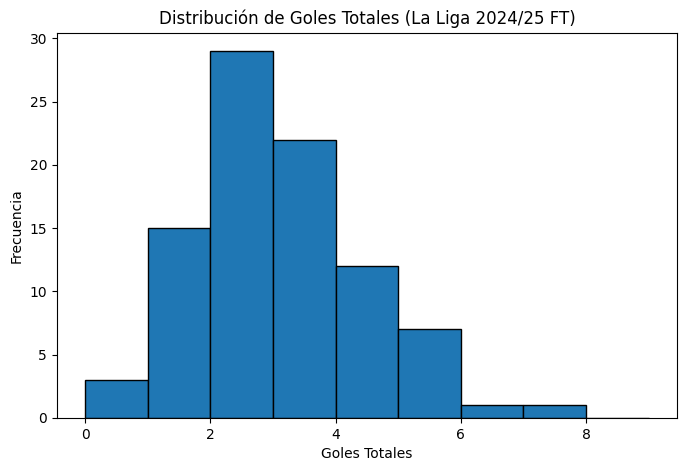

Distribución 1X2 (%):
result
Home Win    45.56
Draw        27.78
Away Win    26.67
Name: proportion, dtype: float64
Home win rate: 45.56%
Over/Under (%): {'O0.5': 96.67, 'O1.5': 80.0, 'O2.5': 47.78, 'O3.5': 23.33, 'U0.5': 3.33, 'U1.5': 20.0, 'U2.5': 52.22, 'U3.5': 76.67}
BTTS (%): 57.78

📊 Análisis para Premier League

--- Premier League 2023 (Completa) ---
Partidos: 380
Goles promedio por partido: 3.279
Goles local promedio: 1.800
Goles visita promedio: 1.479


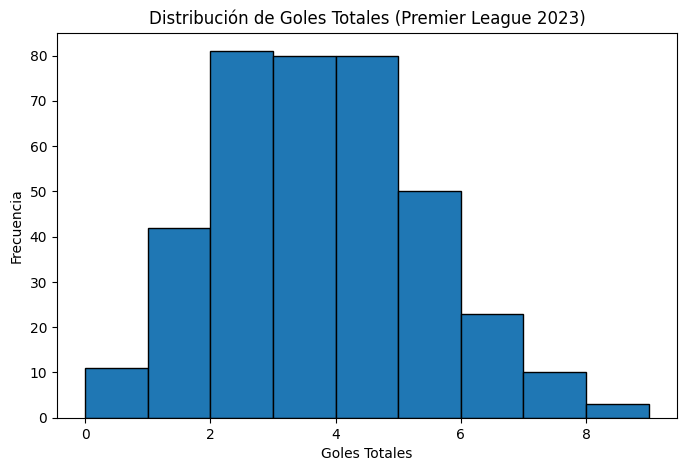

Distribución 1X2 (%):
result
Home Win    46.05
Away Win    32.37
Draw        21.58
Name: proportion, dtype: float64
Home win rate: 46.05%
Over/Under (%): {'O0.5': 97.11, 'O1.5': 86.05, 'O2.5': 64.74, 'O3.5': 43.68, 'U0.5': 2.89, 'U1.5': 13.95, 'U2.5': 35.26, 'U3.5': 56.32}
BTTS (%): 61.58
Top 5 goleadores (GF):
home_team
Manchester City    96
Arsenal            91
Liverpool          86
Newcastle          85
Chelsea            77
dtype: int64
Top 5 menos goleados (GA):
home_team
Arsenal              29
Manchester City      34
Liverpool            41
Everton              51
Manchester United    58
dtype: int64

--- Premier League 2024/25 (Parcial, FT) ---
Partidos: 80
Goles promedio por partido: 2.612
Goles local promedio: 1.475
Goles visita promedio: 1.137


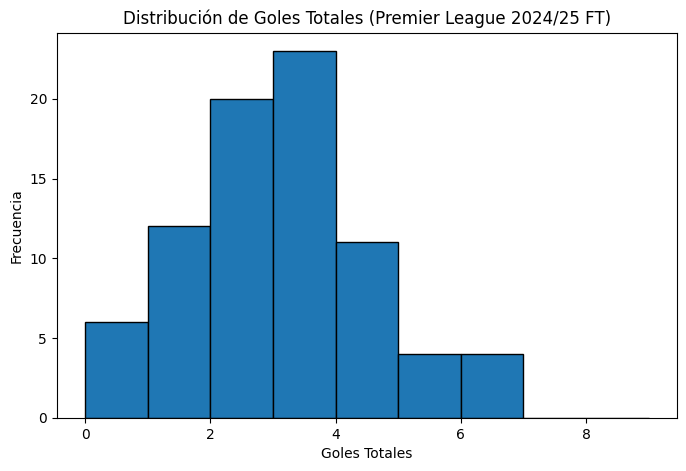

Distribución 1X2 (%):
result
Home Win    47.50
Away Win    28.75
Draw        23.75
Name: proportion, dtype: float64
Home win rate: 47.50%
Over/Under (%): {'O0.5': 92.5, 'O1.5': 77.5, 'O2.5': 52.5, 'O3.5': 23.75, 'U0.5': 7.5, 'U1.5': 22.5, 'U2.5': 47.5, 'U3.5': 76.25}
BTTS (%): 51.25

📊 Análisis para Bundesliga

--- Bundesliga 2023 (Completa) ---
Partidos: 307
Goles promedio por partido: 3.218
Goles local promedio: 1.801
Goles visita promedio: 1.417


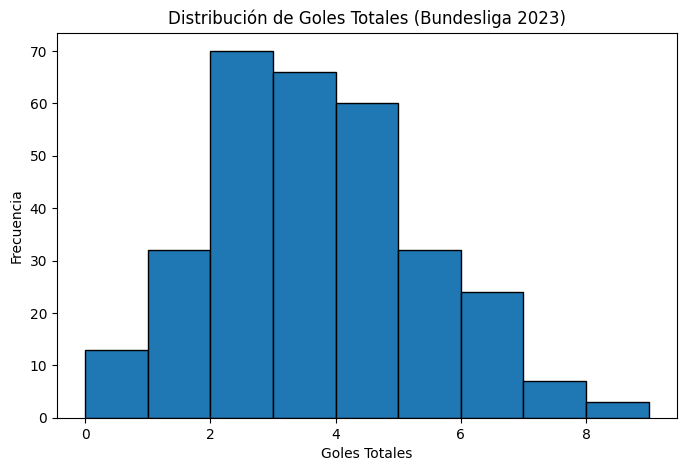

Distribución 1X2 (%):
result
Home Win    43.65
Away Win    29.97
Draw        26.38
Name: proportion, dtype: float64
Home win rate: 43.65%
Over/Under (%): {'O0.5': 95.77, 'O1.5': 85.34, 'O2.5': 62.54, 'O3.5': 41.04, 'U0.5': 4.23, 'U1.5': 14.66, 'U2.5': 37.46, 'U3.5': 58.96}
BTTS (%): 61.56
Top 5 goleadores (GF):
Bayern Munich        94.0
Bayer Leverkusen     89.0
VfB Stuttgart        78.0
RB Leipzig           77.0
Borussia Dortmund    68.0
dtype: float64
Top 5 menos goleados (GA):
Fortuna Dusseldorf     0.0
Bayer Leverkusen      24.0
VfB Stuttgart         39.0
RB Leipzig            39.0
Borussia Dortmund     43.0
dtype: float64

--- Bundesliga 2024/25 (Parcial, FT) ---
Partidos: 63
Goles promedio por partido: 3.302
Goles local promedio: 1.698
Goles visita promedio: 1.603


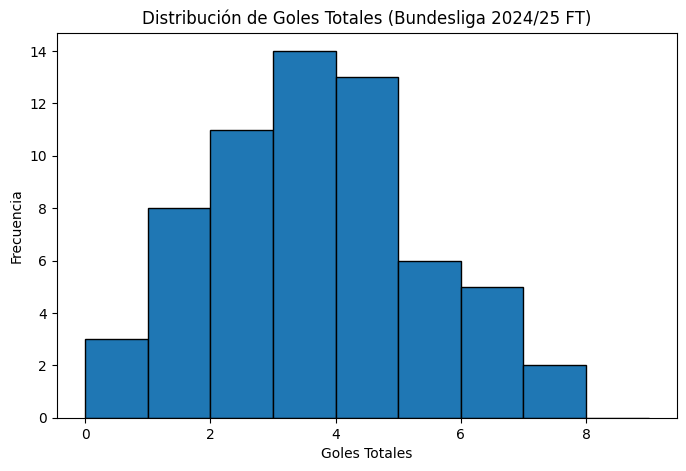

Distribución 1X2 (%):
result
Away Win    39.68
Home Win    39.68
Draw        20.63
Name: proportion, dtype: float64
Home win rate: 39.68%
Over/Under (%): {'O0.5': 95.24, 'O1.5': 82.54, 'O2.5': 65.08, 'O3.5': 42.86, 'U0.5': 4.76, 'U1.5': 17.46, 'U2.5': 34.92, 'U3.5': 57.14}
BTTS (%): 57.14


In [4]:
os.makedirs('data/analysis', exist_ok=True)

for league in leagues:
    print(f"\n📊 Análisis para {league}")
    
    # 2023
    df23 = data_2023[league]
    df23['result'] = df23.apply(result_row, axis=1)
    
    print(f"\n--- {league} 2023 (Completa) ---")
    print(f"Partidos: {len(df23)}")
    print(f"Goles promedio por partido: {df23['total_goals'].mean():.3f}")
    print(f"Goles local promedio: {df23['goals_home'].mean():.3f}")
    print(f"Goles visita promedio: {df23['goals_away'].mean():.3f}")
    
    plt.figure(figsize=(8, 5))
    plt.hist(df23['total_goals'], bins=range(0, 10), edgecolor='black')
    plt.title(f'Distribución de Goles Totales ({league} 2023)')
    plt.xlabel('Goles Totales')
    plt.ylabel('Frecuencia')
    plt.savefig(f'data/analysis/total_goals_{league.replace(" ", "_")}_2023.png')
    plt.show()
    
    dist23 = (df23['result'].value_counts(normalize=True) * 100).round(2)
    print(f"Distribución 1X2 (%):\n{dist23}")
    print(f"Home win rate: {dist23.get('Home Win', 0):.2f}%")
    
    ou23 = {k: round(v*100, 2) for k, v in ou_rates(df23).items()}
    print(f"Over/Under (%): {ou23}")
    print(f"BTTS (%): {btts_rate(df23) * 100:.2f}")
    
    gf_home = df23.groupby('home_team')['goals_home'].sum()
    gf_away = df23.groupby('away_team')['goals_away'].sum()
    gf = (gf_home.add(gf_away, fill_value=0)).sort_values(ascending=False)
    ga_home = df23.groupby('home_team')['goals_away'].sum()
    ga_away = df23.groupby('away_team')['goals_home'].sum()
    ga = (ga_home.add(ga_away, fill_value=0)).sort_values(ascending=True)
    print(f"Top 5 goleadores (GF):\n{gf.head(5)}")
    print(f"Top 5 menos goleados (GA):\n{ga.head(5)}")
    
    df23.to_csv(f'data/analysis/{league.replace(" ", "_")}_2023_matches.csv', index=False)
    
    # 2024/25
    df25 = data_2025[league]
    df25['result'] = df25.apply(result_row, axis=1)
    
    print(f"\n--- {league} 2024/25 (Parcial, FT) ---")
    print(f"Partidos: {len(df25)}")
    print(f"Goles promedio por partido: {df25['total_goals'].mean():.3f}")
    print(f"Goles local promedio: {df25['goals_home'].mean():.3f}")
    print(f"Goles visita promedio: {df25['goals_away'].mean():.3f}")
    
    plt.figure(figsize=(8, 5))
    plt.hist(df25['total_goals'], bins=range(0, 10), edgecolor='black')
    plt.title(f'Distribución de Goles Totales ({league} 2024/25 FT)')
    plt.xlabel('Goles Totales')
    plt.ylabel('Frecuencia')
    plt.savefig(f'data/analysis/total_goals_{league.replace(" ", "_")}_2024_25.png')
    plt.show()
    
    dist25 = (df25['result'].value_counts(normalize=True) * 100).round(2)
    print(f"Distribución 1X2 (%):\n{dist25}")
    print(f"Home win rate: {dist25.get('Home Win', 0):.2f}%")
    
    ou25 = {k: round(v*100, 2) for k, v in ou_rates(df25).items()}
    print(f"Over/Under (%): {ou25}")
    print(f"BTTS (%): {btts_rate(df25) * 100:.2f}")
    
    df25.to_csv(f'data/analysis/{league.replace(" ", "_")}_2024_25_ft_matches.csv', index=False)

## 📋 Resumen Comparativo

Tabla con métricas clave para 2023 y 2024/25 por liga.

In [5]:
summary_data = []
for league in leagues:
    df23 = data_2023[league]
    df25 = data_2025[league]
    summary_data.append({
        'League': league,
        'Season': '2023',
        'Matches': len(df23),
        'Avg Goals': round(df23['total_goals'].mean(), 2),
        'Avg Home Goals': round(df23['goals_home'].mean(), 2),
        'Avg Away Goals': round(df23['goals_away'].mean(), 2),
        'Home Win %': round((df23['result'].eq('Home Win').mean() * 100), 2),
        'BTTS %': round(btts_rate(df23) * 100, 2),
        'Over 2.5 %': round((df23['total_goals'] > 2.5).mean() * 100, 2)
    })
    summary_data.append({
        'League': league,
        'Season': '2024/25',
        'Matches': len(df25),
        'Avg Goals': round(df25['total_goals'].mean(), 2),
        'Avg Home Goals': round(df25['goals_home'].mean(), 2),
        'Avg Away Goals': round(df25['goals_away'].mean(), 2),
        'Home Win %': round((df25['result'].eq('Home Win').mean() * 100), 2),
        'BTTS %': round(btts_rate(df25) * 100, 2),
        'Over 2.5 %': round((df25['total_goals'] > 2.5).mean() * 100, 2)
    })

df_summary = pd.DataFrame(summary_data)
print("\n📋 Resumen comparativo por liga")
display(df_summary)

df_summary.to_csv('data/analysis/league_summary.csv', index=False)
print("✅ Archivo exportado: data/analysis/league_summary.csv")


📋 Resumen comparativo por liga


,League,Season,Matches,Avg Goals,Avg Home Goals,Avg Away Goals,Home Win %,BTTS %,Over 2.5 %
0,La Liga,2023,380,2.64,1.48,1.16,43.95,49.47,46.05
1,La Liga,2024/25,90,2.61,1.46,1.16,45.56,57.78,47.78
2,Premier League,2023,380,3.28,1.80,1.48,46.05,61.58,64.74
3,Premier League,2024/25,80,2.61,1.48,1.14,47.50,51.25,52.50
4,Bundesliga,2023,307,3.22,1.80,1.42,43.65,61.56,62.54
5,Bundesliga,2024/25,63,3.30,1.70,1.60,39.68,57.14,65.08


✅ Archivo exportado: data/analysis/league_summary.csv


## 💾 Exportación Final

Archivos guardados en `data/analysis/`.

**Para exportar a HTML**:
```bash
jupyter nbconvert --to html notebooks/exploration_laliga.ipynb
```

In [6]:
print("\n✅ EDA finalizado.")
print("💾 Archivos exportados en data/analysis/:")
for league in leagues:
    print(f" - {league.replace(' ', '_')}_2023_matches.csv")
    print(f" - {league.replace(' ', '_')}_2024_25_ft_matches.csv")
    print(f" - total_goals_{league.replace(' ', '_')}_2023.png")
    print(f" - total_goals_{league.replace(' ', '_')}_2024_25.png")
print(" - league_summary.csv")


✅ EDA finalizado.
💾 Archivos exportados en data/analysis/:
 - La_Liga_2023_matches.csv
 - La_Liga_2024_25_ft_matches.csv
 - total_goals_La_Liga_2023.png
 - total_goals_La_Liga_2024_25.png
 - Premier_League_2023_matches.csv
 - Premier_League_2024_25_ft_matches.csv
 - total_goals_Premier_League_2023.png
 - total_goals_Premier_League_2024_25.png
 - Bundesliga_2023_matches.csv
 - Bundesliga_2024_25_ft_matches.csv
 - total_goals_Bundesliga_2023.png
 - total_goals_Bundesliga_2024_25.png
 - league_summary.csv
